In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import seaborn as sns
import scipy.stats as stats
from scipy import stats
from scipy.stats import cauchy
import random
import sympy as sp
from scipy.optimize import fsolve
import matplotlib.patches as mpatches

In [21]:
np.random.seed(101)

In [38]:
# Define parameters
N = 5000
T = 500
M = 50000
dt = 0.01
t0 = 0

pi = np.pi

k = 1
a = 0.1
b = 0.26
c = -65
d = 0 #-1

A = 0.04
B = 5
C = 140

# v_reset = -10/A - B/(2*A)
# v_thresh = 10/A - B/(2*A) 

v_reset = -1000
v_thresh = 1000

Esyn = -70
tauS = 3.043043043043043 # Obtained from having peaks of coupling in paper and in ours aligned

p_jump = 2.7185823035951033

# Heterogeneity parameters for the intrinsic current eta
Delta = 0.02     # half-width of Lorentzian for eta
etaBar = 0.4     # mean intrinsic current

J = stats.cauchy.rvs(loc=etaBar, scale=Delta, size=N)
I = 0

# All-to-all connected, can use single s and p as all neuron receive same input
g = 0.4


In [23]:
v_reset, v_thresh

(-1000, 1000)

In [24]:
# Network simulation functions
def dxdt(t, x, k, a, b, I, Esyn, J, tauS):
    v = x[:N]
    u = x[N:2*N]
    s = x[2*N]
    p = x[-1]
    
    dvdt = k * (A*v**2 + B*v + C - u + I) + J - (v - Esyn)*g*s
    dudt = k * a * (b * v - u)
    dsdt = -s / tauS + p / tauS
    dpdt = -p / tauS
    
    return np.concatenate([dvdt, dudt, [dsdt], [dpdt]])

# Spike event
def v_spike(t, x, k, a, b, I, Esyn, J, tauS):
    return x[:N].max() - v_thresh
v_spike.terminal = True
v_spike.direction = 1

In [25]:
# Define the mean-field ODE system
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g*s)*r + 2.0*A*r*v +  Delta*A/pi
    dvdt = - (pi**2 / A)*(r**2) + A*(v**2) + B*v + C - u + I + etaBar + g*s*(Esyn - v)
    dudt = a*(b*v - u) + d*r
    dsdt = - s / tauS + p / tauS
    dpdt = -(p/tauS) + p_jump*r
    return [drdt, dvdt, dudt, dsdt, dpdt]

findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


Average firing rate 8.512


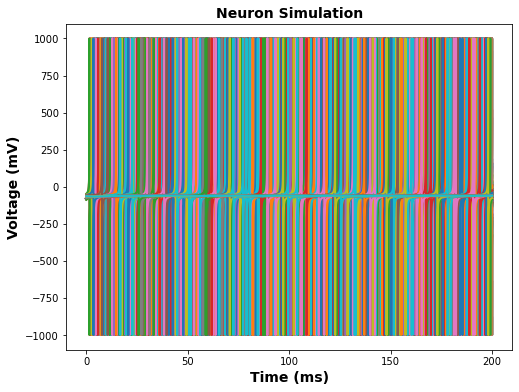

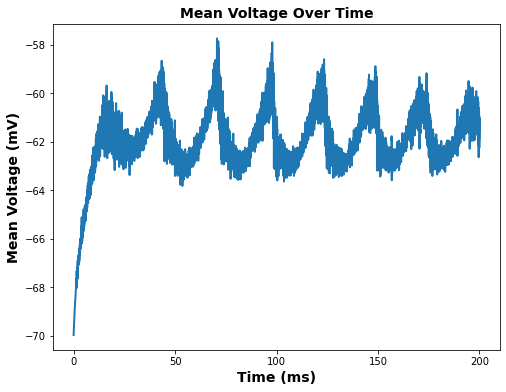

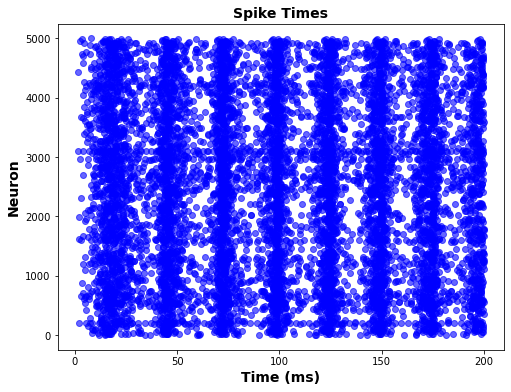

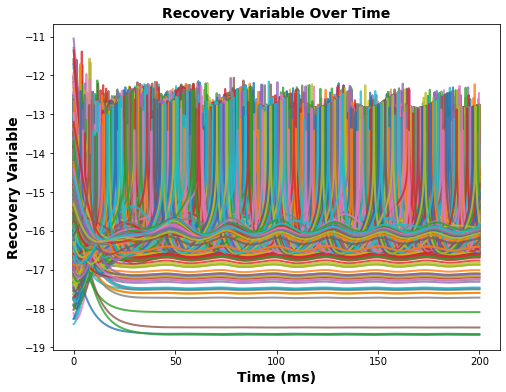

In [53]:
t0 = 0 

# Initial conditions
v_init = np.random.normal(-70, 5, size=(N))
u_init = np.random.normal(-15, 1, size = (N)) # Ask any reason why these were chosen and not ones in page 3 paper
s_init = 0
p_init = 0

t_all = np.array([t0])
y_0 = np.concatenate([v_init, u_init, [s_init], [p_init]])
y_all = np.reshape(y_0, (y_0.shape[0], 1))

# Set up spike time vector
spike_times = np.zeros((M, 2))
spikeCounter = 0    
i = 0

# Simulation loop
while i < M and t0 < T:
    y0 = np.concatenate([v_init, u_init, [s_init], [p_init]])  
   
    sol_v = solve_ivp(dxdt, [t0, T], y0, args=(k, a, b, I, Esyn, J, tauS), dense_output=True, 
                      events=v_spike, rtol=1e-8)
    
    t_end = sol_v.t[-1]
    steps = max([2, int((t_end - t0) / dt)])
    t = np.linspace(t0, t_end, steps)
    y = sol_v.sol(t)
    
    t_all = np.concatenate([t_all, t], axis=0)
    y_all = np.concatenate([y_all, y], axis=1)
    
    t0 = t_end
    v_init = y[:N, -1]
    u_init = y[N:2*N, -1]
    s_init = y[2*N, -1]
    p_init = y[-1, -1]
    
    if len(sol_v.t_events[0]) > 0:
        spike = v_init.argmax()
        v_init[spike] = v_reset
        u_init[spike] += d
        p_init += p_jump/N #x0 
        
        spike_times[spikeCounter, :] = [t0, spike]
        spikeCounter = spikeCounter + 1
        i += 1

colours = sns.color_palette('deep')
font = {'family': 'Times', 'weight': 'normal', 'size': 18}
plt.rc('font', **font)

# Plot 1: Neuron Simulation
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].T, linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Neuron Simulation', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('NeuronModel.png')

# Plot 2: Mean Voltage Over Time
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Voltage (mV)', fontsize=14, fontweight='bold')
plt.title('Mean Voltage Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('MeanVoltage.png')

# Plot 3: Spike Times Scatter Plot
spike_times = spike_times[:spikeCounter, :]
plt.figure(figsize=(8, 6))
plt.scatter(spike_times[:, 0], spike_times[:, 1], color='blue', alpha=0.6)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Neuron', fontsize=14, fontweight='bold')
plt.title('Spike Times', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.savefig('SpikeTimes.png')

# Plot 4: Recovery Variable
plt.figure(figsize=(8, 6))
plt.plot(t_all, y_all[N:2*N, :].T, linewidth=2, alpha=0.8)
plt.xlabel('Time (ms)', fontsize=14, fontweight='bold')
plt.ylabel('Recovery Variable', fontsize=14, fontweight='bold')
plt.title('Recovery Variable Over Time', fontsize=14, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

average_firing_rate = len(spike_times[spike_times[:, 0] > 100]) / (N * (T - 100))*1000
print("Average firing rate", average_firing_rate)

In [6]:
def compute_sliding_window_firing_rate(spike_times, N, T,
                                       window_size=10,  # ms
                                       step_size=0.05):  # ms
    
    # All spike times (in ms) in sorted order:
    spike_t = spike_times[:, 0]
    # Ensure sorted by time (if not already)
    spike_t_sorted = np.sort(spike_t)

    # We will collect time bins from 0 to T in increments of step_size
    time_bins = np.arange(0, T, step_size)
    fr_array = np.zeros_like(time_bins)

    # Convert ms to s for rates in Hz:
    ms_to_s = 1

    for i, t_start in enumerate(time_bins):
        t_end = t_start + window_size
        # Count how many spikes occurred in [t_start, t_end)
        # "spikes_in_win" is how many spike times fall in that interval
        mask = (spike_t_sorted >= t_start) & (spike_t_sorted < t_end)
        num_spikes_in_window = np.sum(mask)

        # Window duration in seconds
        w_sec = window_size * ms_to_s

        # Rate in spikes/(neuron·second) a.k.a. Hz:
        fr_array[i] = num_spikes_in_window / (N * w_sec)

    return time_bins, fr_array

valid_spikes = spike_times[:spikeCounter, :]  # shape (actual_spike_count, 2)

time_bins, fr_array = compute_sliding_window_firing_rate(valid_spikes, N, T,
                                                         window_size=5,
                                                         step_size=0.05)

plt.figure(figsize=(8,6))
plt.plot(time_bins, fr_array, lw=2)
plt.xlabel("Time (ms)")
plt.ylabel("Population Firing Rate")  # if used ms->s conversion
plt.title("Sliding Window Firing Rate")
plt.show()

mean_firing_rate = np.mean(fr_array)
print(f"Mean Firing Rate: {mean_firing_rate*1e3} Hz")
# After computing time_bins and fr_array as in your code:
time_bins, fr_array = compute_sliding_window_firing_rate(
    valid_spikes, N, T, window_size=5, step_size=0.05
)

# Create a boolean mask selecting only the indices corresponding to < 100 ms
mask_100ms = time_bins < 100  # first 100 ms

# Take the mean of fr_array over those indices
mean_fr_100ms = np.mean(fr_array[mask_100ms])

# If you want the value in Hz (spikes/s), multiply by 1e3
mean_fr_100ms_hz = mean_fr_100ms * 1e3

print(f"Average firing rate in the first 100 ms: {mean_fr_100ms_hz} Hz")


NameError: name 'spike_times' is not defined

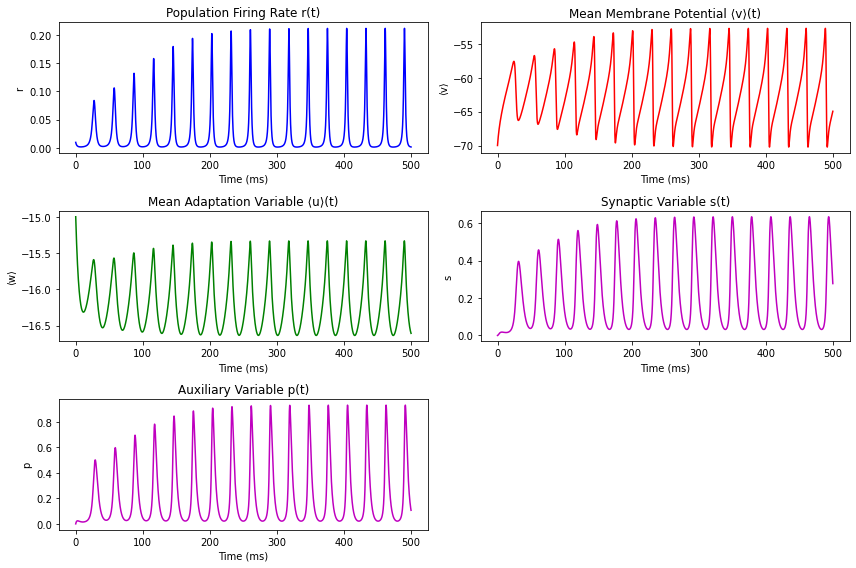

In [163]:
etaBar=0.4
Delta=0.02
T = 500
# Set simulation parameters
t_eval = np.linspace(0, T, 10000)

# Initial conditions for [r(0), ⟨v⟩(0), ⟨u⟩(0), s(0)]
y0 = [9.5853*0.001, -70, -15, 0, 0]

# Solve the ODE system
sol = solve_ivp(mean_field_odes, [0,T], y0, t_eval=t_eval, rtol=1e-8, atol=1e-10)

# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(sol.t, sol.y[0], 'b')
plt.title('Population Firing Rate r(t)')
plt.xlabel('Time (ms)')
plt.ylabel('r')

plt.subplot(3, 2, 2)
plt.plot(sol.t, sol.y[1], 'r')
plt.title('Mean Membrane Potential ⟨v⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨v⟩')

plt.subplot(3, 2, 3)
plt.plot(sol.t, sol.y[2], 'g')
plt.title('Mean Adaptation Variable ⟨u⟩(t)')
plt.xlabel('Time (ms)')
plt.ylabel('⟨w⟩')

plt.subplot(3, 2, 4)
plt.plot(sol.t, sol.y[3], 'm')
plt.title('Synaptic Variable s(t)')
plt.xlabel('Time (ms)')
plt.ylabel('s')

plt.subplot(3, 2, 5)
plt.plot(sol.t, sol.y[4], 'm')
plt.title('Auxiliary Variable p(t)')
plt.xlabel('Time (ms)')
plt.ylabel('p')

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Mean Voltage (v)')

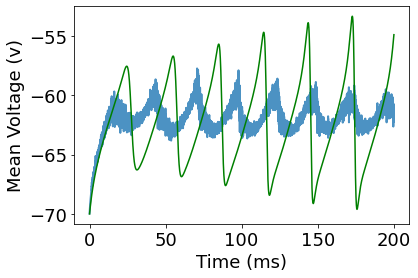

In [55]:
plt.plot(t_all, y_all[:N, :].mean(axis=0), linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[1], 'g', label = 'Mean Field')
plt.xlabel('Time (ms)')
plt.ylabel('Mean Voltage (v)')


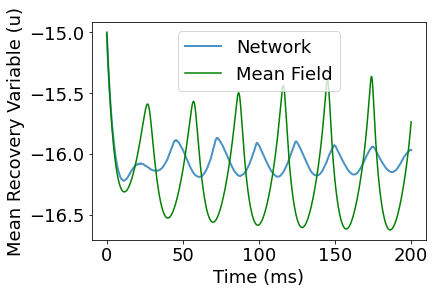

In [56]:
plt.plot(t_all, y_all[N:2*N, :].mean(axis=0), linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[2], 'g', label = 'Mean Field')
plt.xlabel('Time (ms)')
plt.ylabel('Mean Recovery Variable (u)')
plt.legend()

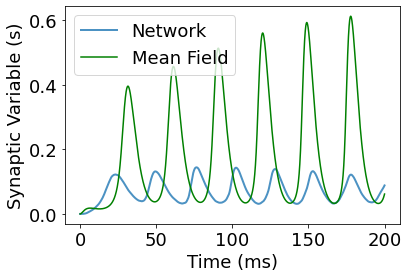

In [57]:
plt.plot(t_all, y_all[-2, :], linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[3], 'g', label = 'Mean Field')
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Variable (s)')
plt.legend()

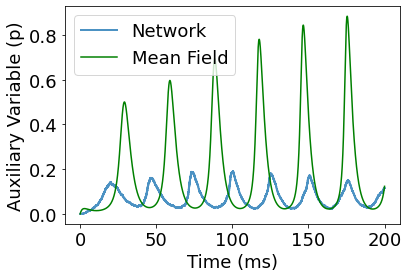

In [58]:
plt.plot(t_all, y_all[-1, :], linewidth=2, alpha=0.8, label = 'Network')
plt.plot(sol.t, sol.y[4], 'g', label = 'Mean Field')
plt.ylabel('Auxiliary Variable (p)')
plt.xlabel('Time (ms)')
plt.legend()

Text(0, 0.5, 'Firing Rate (r)')

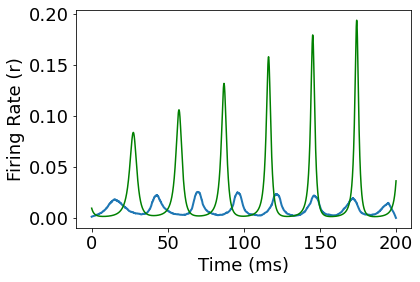

In [59]:
plt.plot(time_bins, fr_array, lw=2, label = 'Network')
plt.plot(sol.t, sol.y[0], 'g', label = 'Mean Field')
plt.xlabel('Time (ms)')
plt.ylabel('Firing Rate (r)')

# Fixed Point, Bifurcation and Trajectory Plot for $\bar{\eta}$

In [132]:
# Getting Conditions for initial guess
r_guess = sol.y[0][-1]
print('r = ', r_guess)
v_guess = sol.y[1][-1]
print('v = ', v_guess)
u_guess = sol.y[2][-1]
print('u = ' ,u_guess)
s_guess = sol.y[3][-1]
print('s = ', s_guess)
p_guess = sol.y[4][-1]
print('p = ', p_guess)

r =  0.0023114246671253253
v =  -63.78150621318483
u =  -16.58319161517716
s =  0.019121868424987337
p =  0.019121868229754917


In [100]:
etaBar_values = np.linspace(-0.35, 0.55, 19)
print(etaBar_values)

[-3.50000000e-01 -3.00000000e-01 -2.50000000e-01 -2.00000000e-01
 -1.50000000e-01 -1.00000000e-01 -5.00000000e-02  5.55111512e-17
  5.00000000e-02  1.00000000e-01  1.50000000e-01  2.00000000e-01
  2.50000000e-01  3.00000000e-01  3.50000000e-01  4.00000000e-01
  4.50000000e-01  5.00000000e-01  5.50000000e-01]


In [133]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [r_guess, v_guess]  # initial guesses for r, v
etaBar_values = np.linspace(-0.35, 0.55, 19)

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]


etaBar = -0.35, Fixed point (r, v, u, s, p): 0.0023114246663367244, -63.78150621294277, -16.58319161536512, 0.019121868378126683, 0.019121868378126683
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.6263032587282567e-18, -1.6313339568085894e-14]
du/dt, ds/dt, dp/dt: [0.0, -8.673617379884035e-19, -8.673617379884035e-19]
etaBar = -0.30, Fixed point (r, v, u, s, p): 0.0025227081121262994, -63.65742967044526, -16.55093171431577, 0.020869766243761363, 0.020869766243761363
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.3286897623809857e-15, 1.6371626276878715e-13]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
etaBar = -0.25, Fixed point (r, v, u, s, p): 0.0027734934599490044, -63.53296345852669, -16.51857049921694, 0.022944453981618134, 0.022944453981618134
Residuals (should be close to zero):
dr/dt, dv/dt: [-4.220473796834323e-15, 1.3244128016509649e-12]
du/dt, ds/dt, dp/dt: [0.0, 8.673617379884035e-19, 8.673617379884035e-19]
etaBar = -0.20, Fixed point (r, v, u, s, p): 0.003072614637

In [165]:
r_fp =  0.011990301317978765
v_fp = -62.269508196375476
u_fp = -16.190072131057626
s_fp = 0.09919292069329683
p_fp = 0.09919292069329683
etaBar = 0.4
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-2.12378240e-02  9.59224105e-04  0.00000000e+00 -4.79612053e-03
   0.00000000e+00]
 [-5.91697653e+00 -2.12378240e-02 -1.00000000e+00 -3.09219672e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.3488665116405837+0.0731832791114304j)
Corresponding eigenvector:
[ 8.00961589e-04+0.00037776j -9.85097584e-01+0.j
  9.47253863e-02+0.02785555j -1.36540758e-01+0.01358321j
  5.38809141e-03-0.03124455j]

Eigenvalue 2: (-0.3488665116405837-0.0731832791114304j)
Corresponding eigenvector:
[ 8.00961589e-04-0.00037776j -9.85097584e-01-0.j
  9.47253863e-02-0.02785555j -1.36540758e-01-0.01358321j
  5.38809141e-03+0.03124455j]

Eigenvalue 3: (-0.00033555875136042414+0.19929487880985636j)
Corresponding eigenvector:


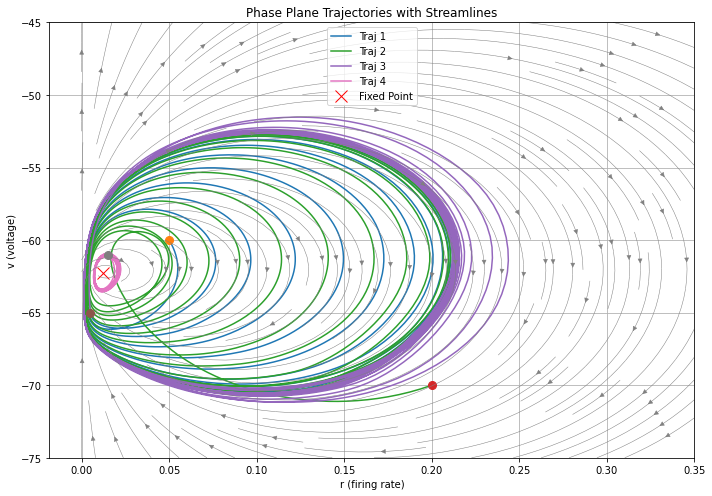

In [166]:
r_fp =  0.011990301317978765
v_fp = -62.269508196375476
u_fp = -16.190072131057626
s_fp = 0.09919292069329683
p_fp = 0.09919292069329683

etaBar = 0.4
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.35, 25)
v = np.linspace(-75, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.xlabel('r (firing rate)')
plt.ylabel('v (voltage)')
plt.title('Phase Plane Trajectories with Streamlines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [139]:
r_fp = 0.013007086250430773
v_fp = -62.206697655332206
u_fp = -16.173741390386375
s_fp = 0.10760454142676587
p_fp = 0.10760454142676587
etaBar = 0.45
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-1.95776290e-02  1.04056690e-03  0.00000000e+00 -5.20283450e-03
   0.00000000e+00]
 [-6.41873979e+00 -1.95776290e-02 -1.00000000e+00 -3.11732094e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.3502280402904194+0.07589731924478368j)
Corresponding eigenvector:
[ 8.59229103e-04+0.0004176j  -9.85158533e-01+0.j
  9.37392426e-02+0.02843229j -1.36334209e-01+0.01400502j
  5.73061858e-03-0.03240854j]

Eigenvalue 2: (-0.3502280402904194-0.07589731924478368j)
Corresponding eigenvector:
[ 8.59229103e-04-0.0004176j  -9.85158533e-01-0.j
  9.37392426e-02-0.02843229j -1.36334209e-01-0.01400502j
  5.73061858e-03+0.03240854j]

Eigenvalue 3: (0.0036489500516750707+0.2038307901224919j)
Corresponding eigenvector:
[

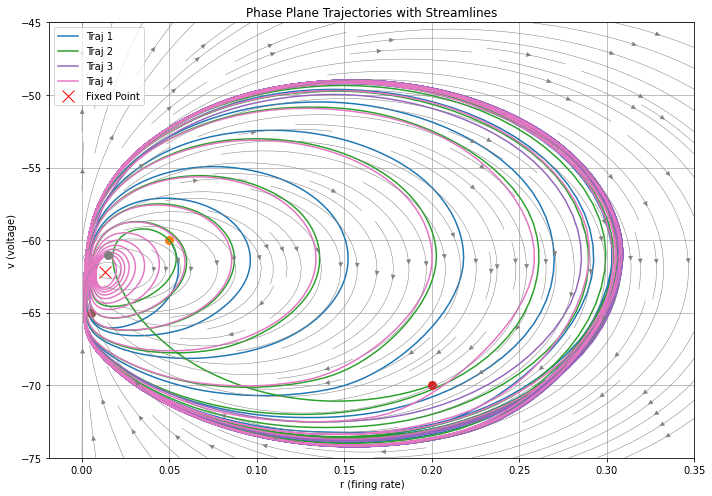

In [167]:

r_fp = 0.013007086250430773
v_fp = -62.206697655332206
u_fp = -16.173741390386375
s_fp = 0.10760454142676587
p_fp = 0.10760454142676587

etaBar = 0.45
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.35, 25)
v = np.linspace(-75, -45, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.xlabel('r (firing rate)')
plt.ylabel('v (voltage)')
plt.title('Phase Plane Trajectories with Streamlines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
r_fp = 0.010982947698586133 
v_fp = -62.335525293507914 
u_fp = -16.20723657631206
s_fp = 0.09085932297722518
p_fp = 0.09085932297722518
etaBar = 0.35
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-2.31857527e-02  8.78635816e-04  0.00000000e+00 -4.39317908e-03
   0.00000000e+00]
 [-5.41986745e+00 -2.31857527e-02 -1.00000000e+00 -3.06578988e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.34749486116064887+0.0703841591624634j)
Corresponding eigenvector:
[ 7.42779898e-04+0.00033912j -9.85034918e-01+0.j
  9.57377194e-02+0.0272265j  -1.36741036e-01+0.01313409j
  5.04156807e-03-0.03004192j]

Eigenvalue 2: (-0.34749486116064887-0.0703841591624634j)
Corresponding eigenvector:
[ 7.42779898e-04-0.00033912j -9.85034918e-01-0.j
  9.57377194e-02-0.0272265j  -1.36741036e-01-0.01313409j
  5.04156807e-03+0.03004192j]

Eigenvalue 3: (-0.0046849558411846005+0.1948853378729278j)
Corresponding eigenvector:


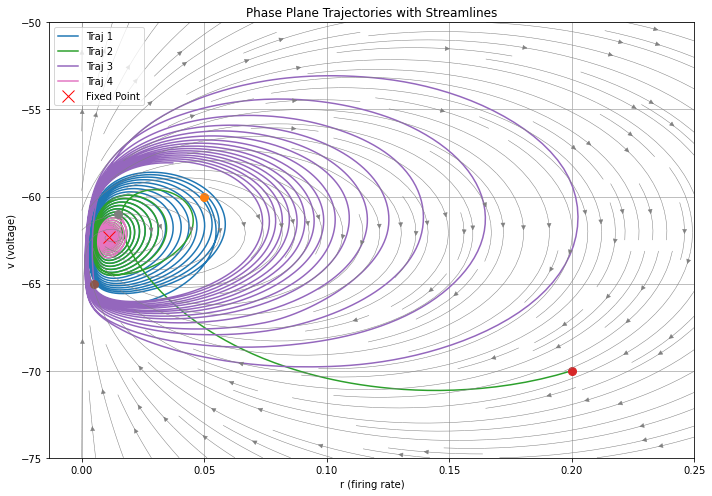

In [143]:
r_fp = 0.010982947698586133 
v_fp = -62.335525293507914 
u_fp = -16.20723657631206
s_fp = 0.09085932297722518
p_fp = 0.09085932297722518
etaBar = 0.35
# Define your mean-field equations explicitly
def mean_field_odes(t, y):
    r, v, u, s, p = y
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / pi
    dvdt = -(pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
    dudt = a * (b * v - u) + d * r
    dsdt = - s / tauS + p / tauS
    dpdt = - (p / tauS) + p_jump * r
    return [drdt, dvdt, dudt, dsdt, dpdt]

# Set up simulation
t_span = [0, 500]
t_eval = np.linspace(*t_span, 10000)

# Choose initial conditions
initial_conditions = [
    [0.05, -60, -15, 0.1, 0.1],
    [0.2, -70, -18, 0.08, 0.08],
    [0.005, -65, -17, 0.05, 0.05],
    [0.015, -61, -16, 0.1, 0.1]
]

# Solve the system explicitly
solutions = [solve_ivp(mean_field_odes, t_span, y0, t_eval=t_eval) for y0 in initial_conditions]

# Plot trajectories explicitly
plt.figure(figsize=(10, 7))

for idx, sol in enumerate(solutions):
    plt.plot(sol.y[0], sol.y[1], label=f'Traj {idx+1}')
    plt.plot(sol.y[0][0], sol.y[1][0], 'o', markersize=8)

# Mark fixed point explicitly
plt.plot(r_fp, v_fp, 'rx', markersize=12, label='Fixed Point')


# Streamlines explicitly
r = np.linspace(0, 0.25, 25)
v = np.linspace(-75, -50, 25)
R, V = np.meshgrid(r, v)

# Evaluate dr/dt and dv/dt explicitly
U, W = np.zeros(R.shape), np.zeros(V.shape)
for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        dydt = mean_field_odes(0, [R[i,j], V[i,j], u_fp, s_fp, p_fp])
        U[i,j], W[i,j] = dydt[0], dydt[1]

# Add streamlines
plt.streamplot(R, V, U, W, color='gray', density=1.5, linewidth=0.5)
plt.xlabel('r (firing rate)')
plt.ylabel('v (voltage)')
plt.title('Phase Plane Trajectories with Streamlines')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

etaBar = 0.4, Max real eigenvalue: -0.000336, Stability: Stable
etaBar = 0.40111111111111114, Max real eigenvalue: -0.000243, Stability: Stable
etaBar = 0.40222222222222226, Max real eigenvalue: -0.000151, Stability: Stable
etaBar = 0.4033333333333333, Max real eigenvalue: -0.000059, Stability: Stable
etaBar = 0.40444444444444444, Max real eigenvalue: 0.000033, Stability: Unstable
etaBar = 0.40555555555555556, Max real eigenvalue: 0.000125, Stability: Unstable
etaBar = 0.4066666666666667, Max real eigenvalue: 0.000216, Stability: Unstable
etaBar = 0.40777777777777774, Max real eigenvalue: 0.000307, Stability: Unstable
etaBar = 0.40888888888888886, Max real eigenvalue: 0.000399, Stability: Unstable
etaBar = 0.41, Max real eigenvalue: 0.000489, Stability: Unstable


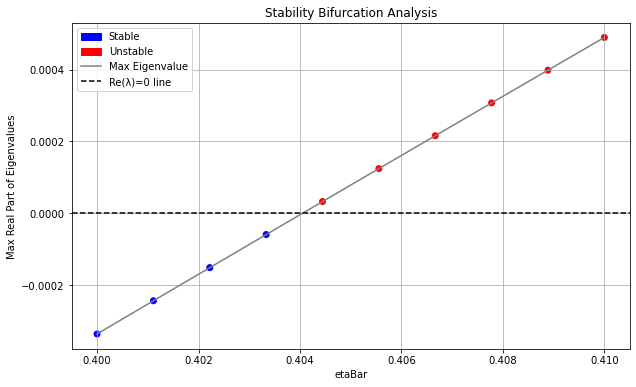

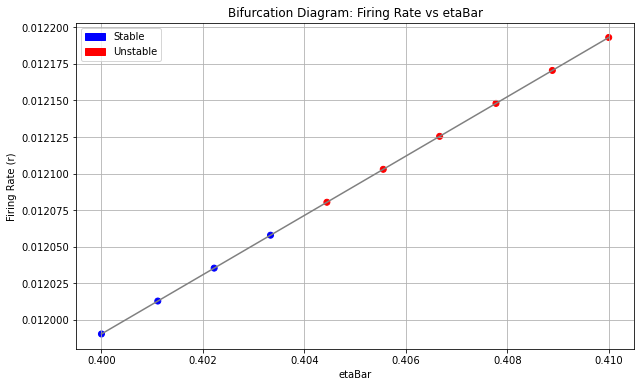

In [171]:

# Storage arrays
etaBar_values = np.linspace(0.4,0.41,10)
max_real_eigvals = []
r_fixed = []
stabilities = []

# Initial guess
initial_guess = [r_guess, v_guess]

for etaBar in etaBar_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar,), full_output=True)
    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)
        
        # Jacobian at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        print(f"etaBar = {etaBar:}, Max real eigenvalue: {max_real_part:.6f}, Stability: {stabilities[-1]}")

        # Update initial guess for next iteration
        initial_guess = [r_fp, v_fp]

# Convert to arrays
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
etaBar_values = np.array(etaBar_values)
stabilities = np.array(stabilities)

# Define colors based on stability
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]

# Custom legend handles
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# Plot max eigenvalue vs etaBar with color change
plt.figure(figsize=(10,6))
plt.plot(etaBar_values, max_real_eigvals, color='gray')
plt.scatter(etaBar_values, max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel('etaBar')
plt.ylabel('Max Real Part of Eigenvalues')
plt.title('Stability Bifurcation Analysis')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch, plt.Line2D([0], [0], color='gray', label="Max Eigenvalue"), 
                     plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")])
plt.show()

# Plot r vs etaBar with color change
plt.figure(figsize=(10,6))
plt.scatter(etaBar_values, r_fixed, c=colors)
plt.plot(etaBar_values, r_fixed, color = 'gray')
plt.xlabel('etaBar')
plt.ylabel('Firing Rate (r)')
plt.title('Bifurcation Diagram: Firing Rate vs etaBar')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch])
plt.show()

etaBar = 0.35, Max real eigenvalue: -0.004685, Stability: Stable
etaBar = 0.36, Max real eigenvalue: -0.003784, Stability: Stable
etaBar = 0.37, Max real eigenvalue: -0.002899, Stability: Stable
etaBar = 0.38, Max real eigenvalue: -0.002030, Stability: Stable
etaBar = 0.39, Max real eigenvalue: -0.001175, Stability: Stable
etaBar = 0.4, Max real eigenvalue: -0.000336, Stability: Stable
etaBar = 0.41000000000000003, Max real eigenvalue: 0.000489, Stability: Unstable
etaBar = 0.42, Max real eigenvalue: 0.001300, Stability: Unstable
etaBar = 0.43, Max real eigenvalue: 0.002097, Stability: Unstable
etaBar = 0.44, Max real eigenvalue: 0.002880, Stability: Unstable
etaBar = 0.45, Max real eigenvalue: 0.003649, Stability: Unstable
etaBar = 0.46, Max real eigenvalue: 0.004405, Stability: Unstable
etaBar = 0.47000000000000003, Max real eigenvalue: 0.005148, Stability: Unstable
etaBar = 0.48000000000000004, Max real eigenvalue: 0.005878, Stability: Unstable
etaBar = 0.49, Max real eigenvalue: 0.

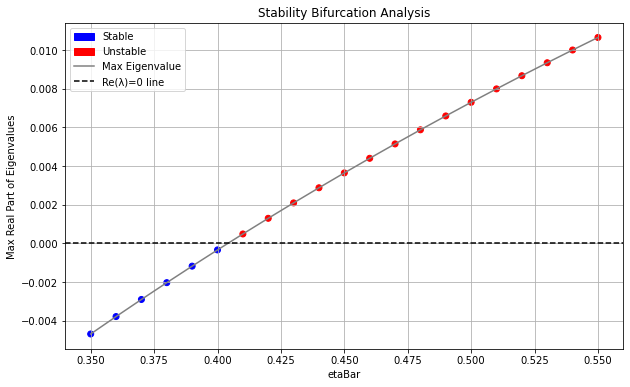

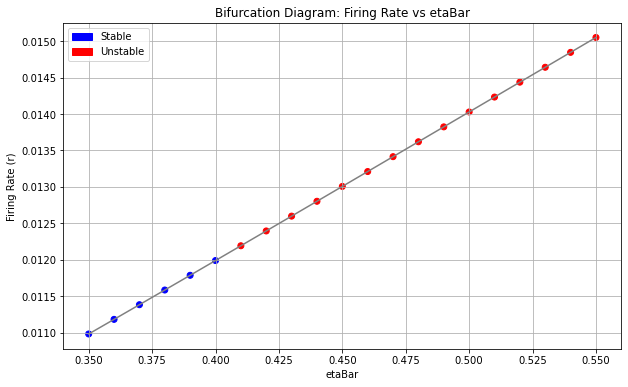

In [174]:

# Storage arrays
etaBar_values = np.linspace(0.35, 0.55, 21)
max_real_eigvals = []
r_fixed = []
stabilities = []

# Initial guess
initial_guess = [r_guess, v_guess]

for etaBar in etaBar_values:
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(etaBar,), full_output=True)
    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)
        
        # Jacobian at the fixed point
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        max_real_eigvals.append(max_real_part)
        r_fixed.append(r_fp)
        stabilities.append('Stable' if max_real_part < 0 else 'Unstable')

        print(f"etaBar = {etaBar:}, Max real eigenvalue: {max_real_part:.6f}, Stability: {stabilities[-1]}")

        # Update initial guess for next iteration
        initial_guess = [r_fp, v_fp]

# Convert to arrays
max_real_eigvals = np.array(max_real_eigvals)
r_fixed = np.array(r_fixed)
etaBar_values = np.array(etaBar_values)
stabilities = np.array(stabilities)

# Define colors based on stability
colors = ['blue' if s == 'Stable' else 'red' for s in stabilities]

# Custom legend handles
stable_patch = mpatches.Patch(color='blue', label='Stable')
unstable_patch = mpatches.Patch(color='red', label='Unstable')

# Plot max eigenvalue vs etaBar with color change
plt.figure(figsize=(10,6))
plt.plot(etaBar_values, max_real_eigvals, color='gray')
plt.scatter(etaBar_values, max_real_eigvals, c=colors)
plt.axhline(0, color='black', linestyle='--', label='Re(λ)=0 line')
plt.xlabel('etaBar')
plt.ylabel('Max Real Part of Eigenvalues')
plt.title('Stability Bifurcation Analysis')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch, plt.Line2D([0], [0], color='gray', label="Max Eigenvalue"), 
                     plt.Line2D([0], [0], color='black', linestyle='--', label="Re(λ)=0 line")])
plt.show()

# Plot r vs etaBar with color change
plt.figure(figsize=(10,6))
plt.scatter(etaBar_values, r_fixed, c=colors)
plt.plot(etaBar_values, r_fixed, color = 'gray')
plt.xlabel('etaBar')
plt.ylabel('Firing Rate (r)')
plt.title('Bifurcation Diagram: Firing Rate vs etaBar')
plt.grid(True)
plt.legend(handles=[stable_patch, unstable_patch])
plt.show()

In [144]:
tol = 1e-12  # precision tolerance

eta_stable = 0.40404609375
eta_unstable = 0.40404612500

initial_guess = [0.01, -65]

while abs(eta_unstable - eta_stable) > tol:
    eta_mid = (eta_stable + eta_unstable) / 2
    
    # Solve fixed points at midpoint explicitly
    fixed_point, _, ier, _ = fsolve(fixed_point_equations, initial_guess, args=(eta_mid,), full_output=True)
    
    if ier == 1:
        r_fp, v_fp = fixed_point
        u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

        # Jacobian at midpoint explicitly
        J = np.zeros((5, 5))
        J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
        J[0, 1] = 2.0 * A * r_fp
        J[0, 3] = -g * r_fp

        J[1, 0] = -(2 * np.pi**2 / A) * r_fp
        J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
        J[1, 2] = -1
        J[1, 3] = g * (Esyn - v_fp)

        J[2, 0] = d
        J[2, 1] = a * b
        J[2, 2] = -a

        J[3, 3] = -1 / tauS
        J[3, 4] = 1 / tauS

        J[4, 0] = p_jump
        J[4, 4] = -1 / tauS

        eigvals = np.linalg.eigvals(J)
        max_real_part = np.max(eigvals.real)

        if max_real_part < 0:
            eta_stable = eta_mid
        else:
            eta_unstable = eta_mid

        # Update initial guess explicitly
        initial_guess = [r_fp, v_fp]

# Final bifurcation point
eta_bifurcation = (eta_stable + eta_unstable) / 2
print(f"Precise Bifurcation point at etaBar = {eta_bifurcation:}")


Precise Bifurcation point at etaBar = 0.4040461000933647


In [164]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [r_guess, v_guess]  # initial guesses for r, v
etaBar_values = [0.4040461000933647]

for etaBar in etaBar_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"etaBar = {etaBar:}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]


etaBar = 0.4040461000933647, Fixed point (r, v, u, s, p): 0.012072306077469041, -62.26431285864538, -16.1887213432478, 0.09987132663063512, 0.09987132663063512
Residuals (should be close to zero):
dr/dt, dv/dt: [4.28439239381212e-12, 3.3141528410496335e-10]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]


In [158]:
r_fp = 0.012072306077469041
v_fp = -62.26431285864538
u_fp = -16.1887213432478
s_fp = 0.09987132663063512
p_fp = 0.09987132663063512
etaBar = 0.4040461000933647
# Jacobian matrix at the fixed point
J = np.zeros((5, 5))

# Evaluate explicitly at fixed points
J[0, 0] = (B - g * s_fp) + 2.0 * A * v_fp
J[0, 1] = 2.0 * A * r_fp
J[0, 2] = 0
J[0, 3] = -g * r_fp
J[0, 4] = 0

J[1, 0] = -(2 * pi**2 / A) * r_fp
J[1, 1] = 2.0 * A * v_fp + B - g * s_fp
J[1, 2] = -1
J[1, 3] = g * (Esyn - v_fp)
J[1, 4] = 0

J[2, 0] = d
J[2, 1] = a * b
J[2, 2] = -a
J[2, 3] = 0
J[2, 4] = 0

J[3, 0] = 0
J[3, 1] = 0
J[3, 2] = 0
J[3, 3] = -1 / tauS
J[3, 4] = 1 / tauS

J[4, 0] = p_jump
J[4, 1] = 0
J[4, 2] = 0
J[4, 3] = 0
J[4, 4] = -1 / tauS

# Print Jacobian matrix
print("Jacobian matrix evaluated at the fixed point:")
print(J)
eigvals, eigvecs = np.linalg.eig(J)

# Print eigenvalues and eigenvectors explicitly
for idx, eigval in enumerate(eigvals):
    eigvec = eigvecs[:, idx]
    print(f"Eigenvalue {idx+1}: {eigval}")
    print(f"Corresponding eigenvector:\n{eigvec}\n")
max_real_eigenvalue = np.max(np.real(eigvals))
print(f"Maximum real eigenvalue: {max_real_eigenvalue}")

Jacobian matrix evaluated at the fixed point:
[[-2.10935593e-02  9.65784486e-04  0.00000000e+00 -4.82892243e-03
   0.00000000e+00]
 [-5.95744426e+00 -2.10935593e-02 -1.00000000e+00 -3.09427486e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.60000000e-02 -1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.28618421e-01
   3.28618421e-01]
 [ 2.71858230e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.28618421e-01]]
Eigenvalue 1: (-0.34897721888642025+0.07340618258246716j)
Corresponding eigenvector:
[ 8.05678331e-04+0.00038094j -9.85102595e-01+0.j
  9.46445287e-02+0.02790413j -1.36524186e-01+0.0136184j
  5.41598932e-03-0.03134022j]

Eigenvalue 2: (-0.34897721888642025-0.07340618258246716j)
Corresponding eigenvector:
[ 8.05678331e-04-0.00038094j -9.85102595e-01-0.j
  9.46445287e-02-0.02790413j -1.36524186e-01-0.0136184j
  5.41598932e-03+0.03134022j]

Eigenvalue 3: (1.1037006074324404e-10+0.19965787256254647j)
Corresponding eigenvector:

# Fixed Points, Bifurcations and Trajectories $\Delta\eta$

In [14]:
# Getting Conditions for initial guess
r_guess = sol.y[0][-1]
print('r = ', r_guess)
v_guess = sol.y[1][-1]
print('v = ', v_guess)
u_guess = sol.y[2][-1]
print('u = ' ,u_guess)
s_guess = sol.y[3][-1]
print('s = ', s_guess)
p_guess = sol.y[4][-1]
print('p = ', p_guess)

r =  -0.1240658349870876
v =  -67.62257296583209
u =  -17.580988084261268
s =  -1.0195260215532018
p =  -1.0210103292984007


In [15]:
np.linspace(-0.02, 0.02, 17)

array([-0.02  , -0.0175, -0.015 , -0.0125, -0.01  , -0.0075, -0.005 ,
       -0.0025,  0.    ,  0.0025,  0.005 ,  0.0075,  0.01  ,  0.0125,
        0.015 ,  0.0175,  0.02  ])

In [34]:
# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# Full system of equations at equilibrium (all derivatives must be zero)
def fixed_point_equations(vars, etaBar):
    r, v = vars 
    u, s, p = equilibrium_conditions(v, r)

    # These two must be zero at equilibrium
    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / (np.pi)
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)


    return [drdt, dvdt]

# Updated solver with all equations:
initial_guess = [0, v_guess]  # initial guesses for r, v
Delta_values = np.linspace(-0.02, 0.02, 17)

for Delta in Delta_values:
    # Solve only for r and v first
    fixed_point = fsolve(fixed_point_equations, initial_guess, args=(etaBar,))
    r_fp, v_fp = fixed_point
    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

    # Check additional conditions explicitly
    dudt = a * (b * v_fp - u_fp) + d * r_fp
    dsdt = -s_fp / tauS + p_jump * r_fp
    dpdt = -p_fp / tauS + p_jump * r_fp  # same as dsdt since p=s

    # Print all equilibrium variables
    print(f"Delta = {Delta:.2f}, Fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")

    # Verify residuals for ALL equations
    print("Residuals (should be close to zero):")
    print("dr/dt, dv/dt:", fixed_point_equations([r_fp, v_fp], etaBar))
    print("du/dt, ds/dt, dp/dt:", [dudt, dsdt, dpdt])

    # Update guess for next iteration
    initial_guess = [r_fp, v_fp]


Delta = -0.02, Fixed point (r, v, u, s, p): 0.00793578536803631, -61.77063866869263, -16.060366053860083, 0.06565087129798229, 0.06565087129798229
Residuals (should be close to zero):
dr/dt, dv/dt: [-5.1348899091085975e-15, 2.707001289792288e-13]
du/dt, ds/dt, dp/dt: [0.0, -3.469446951953614e-18, -3.469446951953614e-18]
Delta = -0.02, Fixed point (r, v, u, s, p): 0.008309208464853599, -61.821103673038984, -16.073486954990138, 0.06874011206394216, 0.06874011206394216
Residuals (should be close to zero):
dr/dt, dv/dt: [-2.0394029889327092e-13, -5.23117937856199e-11]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
Delta = -0.01, Fixed point (r, v, u, s, p): 0.00865003733785507, -61.86621141798263, -16.085214968675484, 0.07155970854221647, 0.07155970854221647
Residuals (should be close to zero):
dr/dt, dv/dt: [-1.2024243905249532e-13, -2.931518916504672e-11]
du/dt, ds/dt, dp/dt: [0.0, 0.0, 0.0]
Delta = -0.01, Fixed point (r, v, u, s, p): 0.008965869122616953, -61.90724744000237, -16.09588433440062, 0

In [33]:


# Define equilibrium conditions explicitly
def equilibrium_conditions(v, r):
    s = r * tauS * p_jump
    p = s
    u = b * v + (d / a) * r
    return u, s, p

# System of equations at equilibrium
def fixed_point_equations(vars, etaBar):
    r, v = vars
    u, s, p = equilibrium_conditions(v, r)

    drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / np.pi
    dvdt = -(np.pi**2 / A) * (r ** 2) + A * (v ** 2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)

    return [drdt, dvdt]

# Range for initial guesses
r_guesses = np.linspace(-10, 10, 20)  # Adjust range as appropriate
v_guesses = np.linspace(-200, 200, 20)

# List to store unique fixed points
found_points = []

# Choose etaBar explicitly
etaBar = 0.4  # adjust as needed

# Scan over a grid of initial guesses
for r_guess in r_guesses:
    for v_guess in np.linspace(-80, 80, 20):
        initial_guess = [r_guess, v_guess]
        fixed_point, info, ier, mesg = fsolve(fixed_point_equations, initial_guess, args=(etaBar,), full_output=True)

        if ier == 1:  # Check convergence
            r_fp, v_fp = fixed_point
            u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

            # Check residual explicitly
            residual = fixed_point_equations(fixed_point, etaBar)
            if np.all(np.abs(residual) < 1e-6):
                # Initialize found_points if not yet done
                try:
                    found_points
                except NameError:
                    found_points = []

                # Check uniqueness and r > 0
                if not any(np.allclose(fixed_point, fp, atol=1e-4) for fp in found_points):
                    found_points.append(fixed_point)
                    r_fp, v_fp = fixed_point
                    u_fp, s_fp, p_fp = equilibrium_conditions(v_fp, r_fp)

                    print(f"Found fixed point (r, v, u, s, p): {r_fp}, {v_fp}, {u_fp}, {s_fp}, {p_fp}")
                    print("Residual:", residual)

# After loop completes, print all distinct found fixed points
print("\nAll distinct physical fixed points (r > 0):")
for fp in found_points:
    print(fp)


Found fixed point (r, v, u, s, p): -0.12301011234218814, -67.56229078397324, -17.566195603833044, -1.0176335018150386, -1.0176335018150386
Residual: [-1.0397498834135988e-16, 1.6653345369377348e-14]
Found fixed point (r, v, u, s, p): 0.011990301317975868, -62.26950819637574, -16.190072131057693, 0.09919292069327287, 0.09919292069327287
Residual: [3.539920093165172e-16, -7.799316747991725e-14]

All distinct physical fixed points (r > 0):
[ -0.12301011 -67.56229078]
[ 1.19903013e-02 -6.22695082e+01]


In [74]:
etaBar = 0.4
# Your fixed point values
r, v, u, s, p = -0.12301011234217957, -67.56229078397047, -17.566195603832323, -1.0176335018149676, -1.0176335018149676


# Compute the derivatives at the fixed points explicitly:
drdt = (B - g * s) * r + 2.0 * A * r * v + Delta * A / np.pi
dvdt = -(np.pi**2 / A) * (r**2) + A * (v**2) + B * v + C - u + I + etaBar + g * s * (Esyn - v)
dudt = a * (b * v - u) + d * r
dsdt = -(s / tauS) + p/tauS
dpdt = -(p / tauS) + p_jump * r  # same as dsdt due to s = p

# Print residuals
print("Residuals at the fixed point (should be close to zero):")
print(f"dr/dt = {drdt}")
print(f"dv/dt = {dvdt}")
print(f"du/dt = {dudt}")
print(f"ds/dt = {dsdt}")
print(f"dp/dt = {dpdt}")  # identical to ds/dt


Residuals at the fixed point (should be close to zero):
dr/dt = -2.386274771531971e-14
dv/dt = -2.142730437526552e-13
du/dt = 0.0
ds/dt = 0.0
dp/dt = 0.0
